### ポケモンカードデータについて

#### 1.小売価格データ(pokemon_cards_with_titles.csv)の前処理：2つの商品が1行で書かれている行31,48 を2行に分離してpokemon_cards_with_titles_cleansing.csvとして保存

#### 2.買取価格データ(pack_only.csv)の前処理：まずパック名について不要な文字列を指定してフィルタリングしfiltered_pack_only.csvとして保存，その後データを結合させるために同一商品のパック名を小売価格データと一致させ，filtered_pack_only_cleansing.csvとして保存

##### ライブラリのインポート

In [1]:
import pandas as pd

##### CSVファイルの読み込み

In [2]:
file_path = "pack_only.csv"
df = pd.read_csv(file_path)

##### 除外するキーワードリストの定義

In [3]:
exclude_keywords = [
    'ギフトパック', 'スターターパック', 'VSパック', '構築',
    'コレクションシート', 'デッキ', 'スペシャル', 'プレミアム',
    'サザンアイランド', '映画', 'タイプユニット'
]

pattern = '|'.join(exclude_keywords)

##### フィルタ処理の実行とCSVファイルへの保存

In [4]:
filtered_df = df[~df['カード名/商品名'].str.contains(pattern, na=False)]
output_path = "filtered_pack_only.csv"
filtered_df.to_csv(output_path, index=False, encoding='utf-8-sig')

#### 3.前処理した2つのCSVファイルを結合し，merged_data.csvとして保存

##### CSVファイルの読み込み

In [5]:
df1 = pd.read_csv("pokemon_cards_with_titles_cleansing.csv")
df2 = pd.read_csv("filtered_pack_only_cleansing.csv")

##### パック名で結合

In [6]:
merged_df = pd.merge(df1, df2, on="パック名", how="left")

##### 列の順番を並び変える

In [7]:
desired_order = ["パック名", "発売日", "希望小売価格", "買取価格", "カード枚数"]
merged_df = merged_df[desired_order]

##### CSVとして保存

In [8]:
output_filename = "merged_data.csv"
merged_df.to_csv(output_filename, index=False, encoding="utf-8-sig")

#### 4.マージしたファイルの欠損値(買取価格)の補完：欠損データには2種類存在し，種類ごとに次のように補完しmerged_data_all.csvとして保存
##### 4.1 該当商品のBOXデータに限りカードラッシュに買取価格が存在する場合：BOX価格/パック数により，疑似的な1パックの価格を算出し入力(小数点切捨)
##### 4.2 カードラッシュに価格データが存在しない場合：別サイトの買取価格を参照し入力

### 貴金属（金/銀/プラチナ）データについて

#### Investing.comより1996/11/01-2025/05/01までの月次データをそれぞれgold_data.csv, silver_data.csv, plutinum_data.csv として保存

#### 5.ポケモンカード及び貴金属データのROI/CAGR計算と可視化

##### ライブラリのインポートとフォント設定

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['font.family'] = 'Meiryo' 

##### ポケモンカードデータ読み込みと前処理

In [11]:
poke_df = pd.read_csv("merged_data_all.csv")

poke_df["発売日"] = pd.to_datetime(poke_df["発売日"], format="%Y年%m月%d日", errors='coerce')
poke_df["希望小売価格"] = poke_df["希望小売価格"].astype(str).str.replace("円", "").str.replace(",", "").astype(float)
poke_df["買取価格"] = poke_df["買取価格"].astype(str).str.replace("¥", "").str.replace(",", "").astype(float)

##### ポケモンカードデータのROI/CAGRの計算

In [12]:
today = datetime.today()

poke_df["経過年数"] = (today - poke_df["発売日"]).dt.days / 365.25
poke_df["ROI"] = (poke_df["買取価格"] - poke_df["希望小売価格"]) / poke_df["希望小売価格"]
poke_df["CAGR"] = (poke_df["買取価格"] / poke_df["希望小売価格"]) ** (1 / poke_df["経過年数"]) - 1

# 平均 ROI（倍率）と CAGR（年利）
poke_mean_roi = poke_df["ROI"].mean()
poke_mean_cagr = poke_df["CAGR"].mean()

##### 貴金属データの読み込み関数の定義と取得

In [13]:
def load_and_calc_cagr(csv_path):
    df = pd.read_csv(csv_path)
    df["日付け"] = pd.to_datetime(df["日付け"])
    df["終値"] = df["終値"].astype(str).str.replace(",", "").astype(float)
    df_sorted = df.sort_values("日付け")
    
    start_price = df_sorted.iloc[0]["終値"]
    end_price = df_sorted.iloc[-1]["終値"]
    years = (df_sorted.iloc[-1]["日付け"] - df_sorted.iloc[0]["日付け"]).days / 365.25
    
    roi = (end_price - start_price) / start_price
    cagr = (end_price / start_price) ** (1 / years) - 1
    return roi, cagr

# 各金属のデータ取得
gold_roi, gold_cagr = load_and_calc_cagr("gold_data.csv")
silver_roi, silver_cagr = load_and_calc_cagr("silver_data.csv")
platinum_roi, platinum_cagr = load_and_calc_cagr("platinum_data.csv")

##### データの統合と可視化

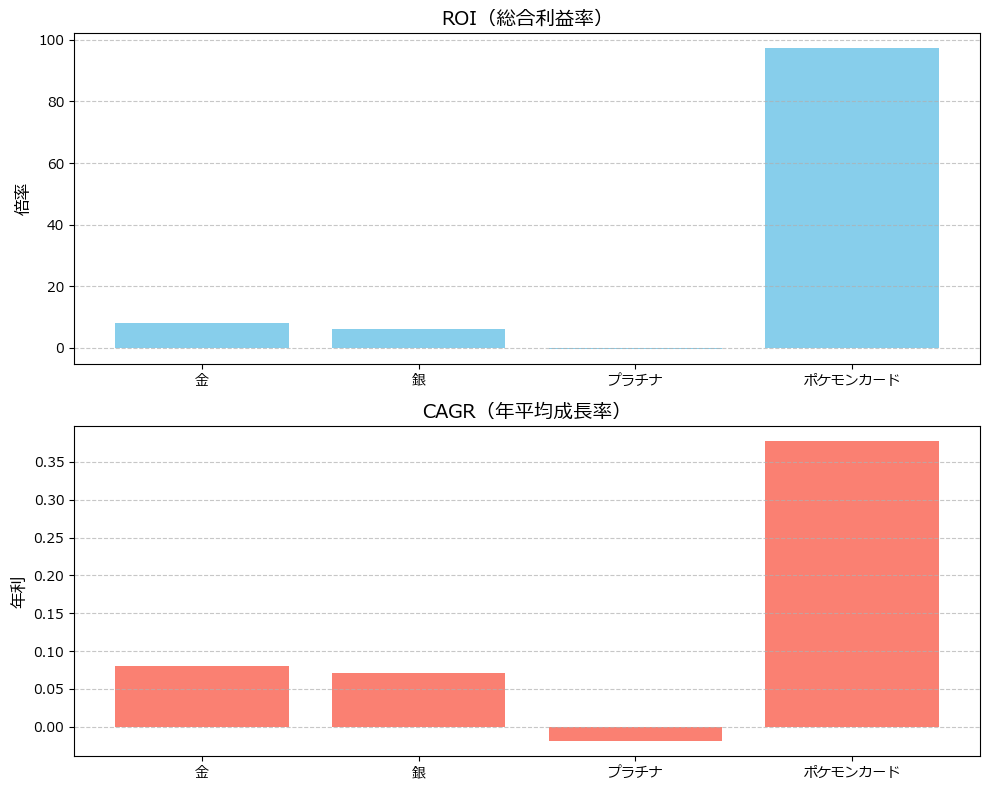

In [14]:
# 表示データまとめ
labels = ["金", "銀", "プラチナ", "ポケモンカード"]
roi_values = [gold_roi, silver_roi, platinum_roi, poke_mean_roi]
cagr_values = [gold_cagr, silver_cagr, platinum_cagr, poke_mean_cagr]

# 棒グラフ（上下2段）
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# ROI（倍率）
axes[0].bar(labels, roi_values, color='skyblue')
axes[0].set_title("ROI（総合利益率）", fontsize=14)
axes[0].set_ylabel("倍率", fontsize=12)
axes[0].grid(True, axis='y', linestyle='--', alpha=0.7)

# CAGR（年利）
axes[1].bar(labels, cagr_values, color='salmon')
axes[1].set_title("CAGR（年平均成長率）", fontsize=14)
axes[1].set_ylabel("年利", fontsize=12)
axes[1].grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()